# Importing Packages and Data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier
import xgboost as xgb
from sklearn.ensemble import VotingClassifier, StackingClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostClassifier

In [2]:
df = pd.read_csv('churn_data.csv')

# Data PreProcessing

In [3]:
# Converts total charges from string to float
df['Total Charges'] = df['Total Charges'].replace(r'^\s*$', np.nan, regex=True)
df['Total Charges'] = df['Total Charges'].astype(float)
# Choosing variables apart from Churn Label, Churn reason (not applicable for modelling)
df1 = df[['Country', 'State', 'City','Zip Code', 'Latitude', 'Longitude', 'Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Tenure Months', 'Phone Service', 'Multiple Lines', 'Internet Service', 'Online Security','Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV','Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method','Monthly Charges', 'Total Charges','Churn Value']]

In [4]:
# One hot encodeing all variables
df_encoded = pd.get_dummies(df1, columns=['Gender', 'Senior Citizen', 'Partner', 'Dependents','Phone Service', 'Multiple Lines', 'Internet Service', 'Online Security','Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV','Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method'])

In [5]:
# Dropping dummy variables
df_encoded = df_encoded.drop(['Multiple Lines_No phone service', 'Online Security_No internet service', 'Online Backup_No internet service','Device Protection_No internet service', 'Tech Support_No internet service', 'Streaming TV_No internet service', 'Streaming Movies_No internet service', 'Gender_Female', 'Senior Citizen_No', 'Partner_No', 'Paperless Billing_No', 'Dependents_No', 'Phone Service_No', 'Multiple Lines_No', 'Internet Service_No', 'Online Security_No', 'Online Backup_No', 'Device Protection_No', 'Tech Support_No', 'Streaming TV_No', 'Streaming Movies_No', 'Contract_One year', 'Payment Method_Mailed check'], axis = 1)
# Scaling continuous variable
scaler = StandardScaler()
df_encoded[['Tenure Months', 'Monthly Charges', 'Total Charges']] = scaler.fit_transform(df_encoded[['Tenure Months', 'Monthly Charges', 'Total Charges']])
df_encoded.head()

,Country,State,City,Zip Code,Latitude,Longitude,Tenure Months,Monthly Charges,Total Charges,Churn Value,...,Device Protection_Yes,Tech Support_Yes,Streaming TV_Yes,Streaming Movies_Yes,Contract_Month-to-month,Contract_Two year,Paperless Billing_Yes,Payment Method_Bank transfer (automatic),Payment Method_Credit card (automatic),Payment Method_Electronic check
0,United States,California,Los Angeles,90003,33.964131,-118.272783,-1.236724,-0.362660,-0.959649,1,...,0,0,0,0,1,0,1,0,0,0
1,United States,California,Los Angeles,90005,34.059281,-118.307420,-1.236724,0.197365,-0.940457,1,...,0,0,0,0,1,0,1,0,0,1
2,United States,California,Los Angeles,90006,34.048013,-118.293953,-0.992402,1.159546,-0.645369,1,...,1,0,1,1,1,0,1,0,0,1
3,United States,California,Los Angeles,90010,34.062125,-118.315709,-0.177995,1.330711,0.336516,1,...,1,1,1,1,1,0,1,0,0,1
4,United States,California,Los Angeles,90015,34.039224,-118.266293,0.677133,1.294151,1.214589,1,...,1,0,1,1,1,0,1,1,0,0


In [6]:
df_la = df_encoded[df_encoded['Zip Code'] == 90012]
df_la.columns

Index(['Country', 'State', 'City', 'Zip Code', 'Latitude', 'Longitude',
       'Tenure Months', 'Monthly Charges', 'Total Charges', 'Churn Value',
       'Gender_Male', 'Senior Citizen_Yes', 'Partner_Yes', 'Dependents_Yes',
       'Phone Service_Yes', 'Multiple Lines_Yes', 'Internet Service_DSL',
       'Internet Service_Fiber optic', 'Online Security_Yes',
       'Online Backup_Yes', 'Device Protection_Yes', 'Tech Support_Yes',
       'Streaming TV_Yes', 'Streaming Movies_Yes', 'Contract_Month-to-month',
       'Contract_Two year', 'Paperless Billing_Yes',
       'Payment Method_Bank transfer (automatic)',
       'Payment Method_Credit card (automatic)',
       'Payment Method_Electronic check'],
      dtype='object')

In [7]:
# Dealing with Latitude and Longitude variables by finding manhatten distance
from math import radians
import math

# Define the central location
central_lat = radians(34.065875)
central_lon = radians(-118.238728)

# Define a function to calculate the Manhattan distance
def manhattan_distance(lat1, lon1, lat2, lon2):
    """Calculate the Manhattan distance between two points."""
    dx = abs(lon2 - lon1) * 6371 * math.cos((lat1 + lat2) / 2)
    dy = abs(lat2 - lat1) * 6371
    return dx + dy

# Apply the function to each row in the DataFrame
df_encoded['manhattan_distance'] = df_encoded.apply(lambda x: manhattan_distance(radians(x['Latitude']), radians(x['Longitude']), central_lat, central_lon), axis=1)

# View the updated DataFrame
df_encoded.head()

,Country,State,City,Zip Code,Latitude,Longitude,Tenure Months,Monthly Charges,Total Charges,Churn Value,...,Tech Support_Yes,Streaming TV_Yes,Streaming Movies_Yes,Contract_Month-to-month,Contract_Two year,Paperless Billing_Yes,Payment Method_Bank transfer (automatic),Payment Method_Credit card (automatic),Payment Method_Electronic check,manhattan_distance
0,United States,California,Los Angeles,90003,33.964131,-118.272783,-1.236724,-0.362660,-0.959649,1,...,0,0,0,1,0,1,0,0,0,14.452214
1,United States,California,Los Angeles,90005,34.059281,-118.307420,-1.236724,0.197365,-0.940457,1,...,0,0,0,1,0,1,0,0,1,7.060907
2,United States,California,Los Angeles,90006,34.048013,-118.293953,-0.992402,1.159546,-0.645369,1,...,0,1,1,1,0,1,0,0,1,7.073653
3,United States,California,Los Angeles,90010,34.062125,-118.315709,-0.177995,1.330711,0.336516,1,...,1,1,1,1,0,1,0,0,1,7.508106
4,United States,California,Los Angeles,90015,34.039224,-118.266293,0.677133,1.294151,1.214589,1,...,0,1,1,1,0,1,1,0,0,5.502956


In [8]:
df_encoded[['manhattan_distance']] = scaler.fit_transform(df_encoded[['manhattan_distance']])
df_features = df_encoded.drop(['Latitude', 'Longitude', 'Zip Code', 'Country', 'State', 'City'], axis=1)
df_features = df_features.dropna()

In [9]:
data = df_features

X = data.drop(['Churn Value'], axis=1)
y = data['Churn Value']


# Split the data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import RandomOverSampler
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
ros = RandomOverSampler(random_state=42)
X_train, y_train = ros.fit_resample(X_train, y_train)


# Ensemble Methods

In [16]:
# Function to evaluate the models with f1, auc and confusion matricies for train and test set
def evaluate_model(name, train_preds, test_preds):
    print(f"Evaluation of {name} model:")
    print("Training set:")
    print("F1 Score (Per Class):", f1_score(y_train, np.round(train_preds), average=None))
    print("AUC Score:", roc_auc_score(y_train, train_preds))
    
    cm_train = confusion_matrix(y_train, np.round(train_preds))
    cm_train_percent = cm_train / cm_train.sum(axis=1, keepdims=True) * 100
    sns.heatmap(cm_train_percent, annot=True, fmt='.2f', cmap='Blues')
    plt.title(f"Confusion matrix ({name} model) - Training set (Percentages)")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    print("Test set:")
    print("F1 Score (Per Class):", f1_score(y_test, np.round(test_preds), average=None))
    print("AUC Score:", roc_auc_score(y_test, test_preds))
    
    cm_test = confusion_matrix(y_test, np.round(test_preds))
    cm_test_percent = cm_test / cm_test.sum(axis=1, keepdims=True) * 100
    sns.heatmap(cm_test_percent, annot=True, fmt='.2f', cmap='Blues')
    plt.title(f"Confusion matrix ({name} model) - Test set (Percentages)")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


Evaluation of Bagging ensemble (Random Forest) model:
Training set:
F1 Score (Per Class): [0.97632552 0.97739581]
AUC Score: 0.9768730426403277


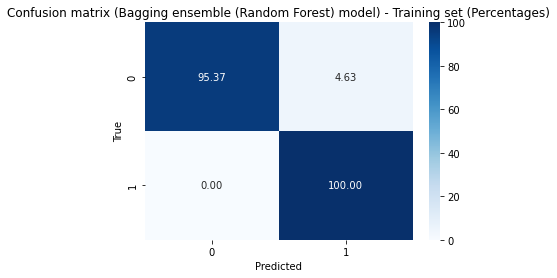

Test set:
F1 Score (Per Class): [0.84979839 0.64096386]
AUC Score: 0.7532108370440787


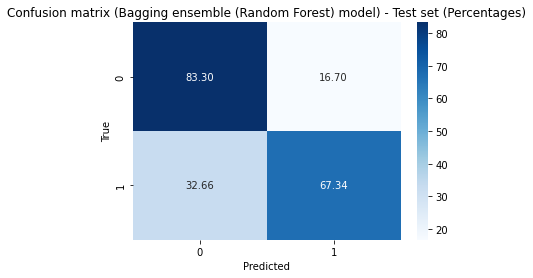

In [17]:
# Evaluate Bagging ensemble (Random Forest)
rfc.fit(X_train, y_train)
bagging_train_preds = rfc.predict(X_train)
bagging_test_preds = rfc.predict(X_test)
evaluate_model("Bagging ensemble (Random Forest)", bagging_train_preds, bagging_test_preds)


In [18]:
# Soft Voting Ensemble, which is tuned after finding optimal weights
# Create a soft voting ensemble without weights
soft_vote = VotingClassifier(
    estimators=[
        ('svm', best_svm_pipe), ('nb', nb), ('lgbm', best_mod),
        ('xgb', lf_xgb), ('ada_boost', ada_boost), ('rfc', rfc), ('catboost', catboost_model)
    ],
    voting='soft'
)

# Set up the search space for weights
param_dist = {
    'weights': [
        np.random.randint(low=0, high=5, size=7) for _ in range(25)
    ]
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    soft_vote, param_distributions=param_dist, n_iter=20,
    scoring='roc_auc', cv=5, n_jobs=-1, verbose=1
)

# Fit the model and find the best weights
random_search.fit(X_train, y_train)

# Get the best parameters from the random search
best_weights = random_search.best_params_['weights']

# Restrict the weights to be no greater than 3
best_weights = np.minimum(best_weights, [5] * len(best_weights))

# Apply the best weights to the soft voting ensemble
soft_vote.set_params(weights=best_weights)

# Fit and predict with the updated soft voting ensemble
soft_vote.fit(X_train, y_train)
soft_vote_train_preds = soft_vote.predict(X_train)
soft_vote_test_preds = soft_vote.predict(X_test)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
0:	learn: 0.6625448	total: 111ms	remaining: 1m 51s
1:	learn: 0.6343008	total: 121ms	remaining: 1m
2:	learn: 0.6108811	total: 131ms	remaining: 43.7s
3:	learn: 0.5941157	total: 140ms	remaining: 34.9s
4:	learn: 0.5762510	total: 158ms	remaining: 31.5s
5:	learn: 0.5631695	total: 165ms	remaining: 27.4s
6:	learn: 0.5496028	total: 173ms	remaining: 24.5s
7:	learn: 0.5370159	total: 182ms	remaining: 22.5s
8:	learn: 0.5265762	total: 190ms	remaining: 20.9s
9:	learn: 0.5171500	total: 196ms	remaining: 19.4s
10:	learn: 0.5105821	total: 215ms	remaining: 19.3s
11:	learn: 0.5035293	total: 221ms	remaining: 18.2s
12:	learn: 0.4985763	total: 231ms	remaining: 17.5s
13:	learn: 0.4939736	total: 239ms	remaining: 16.8s
14:	learn: 0.4885869	total: 255ms	remaining: 16.8s
15:	learn: 0.4832205	total: 263ms	remaining: 16.2s
16:	learn: 0.4786047	total: 274ms	remaining: 15.8s
17:	learn: 0.4745975	total: 283ms	remaining: 15.4s
18:	learn: 0.4713608	total: 294m

174:	learn: 0.3526209	total: 1.84s	remaining: 8.69s
175:	learn: 0.3522228	total: 1.85s	remaining: 8.67s
176:	learn: 0.3518942	total: 1.86s	remaining: 8.65s
177:	learn: 0.3514961	total: 1.87s	remaining: 8.63s
178:	learn: 0.3507961	total: 1.88s	remaining: 8.61s
179:	learn: 0.3504633	total: 1.89s	remaining: 8.59s
180:	learn: 0.3500361	total: 1.9s	remaining: 8.58s
181:	learn: 0.3494627	total: 1.92s	remaining: 8.65s
182:	learn: 0.3490072	total: 1.93s	remaining: 8.63s
183:	learn: 0.3485822	total: 1.94s	remaining: 8.61s
184:	learn: 0.3481334	total: 1.95s	remaining: 8.6s
185:	learn: 0.3478214	total: 1.96s	remaining: 8.58s
186:	learn: 0.3470727	total: 1.98s	remaining: 8.61s
187:	learn: 0.3466055	total: 1.99s	remaining: 8.6s
188:	learn: 0.3463417	total: 2s	remaining: 8.59s
189:	learn: 0.3460847	total: 2.02s	remaining: 8.61s
190:	learn: 0.3457630	total: 2.03s	remaining: 8.6s
191:	learn: 0.3454983	total: 2.04s	remaining: 8.57s
192:	learn: 0.3449992	total: 2.04s	remaining: 8.55s
193:	learn: 0.34448

342:	learn: 0.2915712	total: 3.53s	remaining: 6.75s
343:	learn: 0.2913896	total: 3.54s	remaining: 6.74s
344:	learn: 0.2911617	total: 3.54s	remaining: 6.73s
345:	learn: 0.2908906	total: 3.55s	remaining: 6.72s
346:	learn: 0.2906260	total: 3.56s	remaining: 6.71s
347:	learn: 0.2904305	total: 3.57s	remaining: 6.69s
348:	learn: 0.2899246	total: 3.58s	remaining: 6.68s
349:	learn: 0.2897125	total: 3.59s	remaining: 6.67s
350:	learn: 0.2895008	total: 3.6s	remaining: 6.65s
351:	learn: 0.2893563	total: 3.61s	remaining: 6.64s
352:	learn: 0.2891730	total: 3.62s	remaining: 6.64s
353:	learn: 0.2889856	total: 3.63s	remaining: 6.63s
354:	learn: 0.2887673	total: 3.64s	remaining: 6.62s
355:	learn: 0.2884866	total: 3.65s	remaining: 6.61s
356:	learn: 0.2883326	total: 3.66s	remaining: 6.59s
357:	learn: 0.2878868	total: 3.67s	remaining: 6.58s
358:	learn: 0.2876511	total: 3.68s	remaining: 6.57s
359:	learn: 0.2874677	total: 3.69s	remaining: 6.56s
360:	learn: 0.2872675	total: 3.7s	remaining: 6.55s
361:	learn: 0.

505:	learn: 0.2509404	total: 5.26s	remaining: 5.14s
506:	learn: 0.2507497	total: 5.27s	remaining: 5.13s
507:	learn: 0.2505256	total: 5.28s	remaining: 5.12s
508:	learn: 0.2502023	total: 5.29s	remaining: 5.1s
509:	learn: 0.2499424	total: 5.32s	remaining: 5.11s
510:	learn: 0.2495902	total: 5.33s	remaining: 5.1s
511:	learn: 0.2494685	total: 5.34s	remaining: 5.09s
512:	learn: 0.2492624	total: 5.35s	remaining: 5.08s
513:	learn: 0.2489963	total: 5.36s	remaining: 5.06s
514:	learn: 0.2488114	total: 5.36s	remaining: 5.05s
515:	learn: 0.2485418	total: 5.37s	remaining: 5.04s
516:	learn: 0.2484193	total: 5.38s	remaining: 5.03s
517:	learn: 0.2482796	total: 5.39s	remaining: 5.02s
518:	learn: 0.2481695	total: 5.4s	remaining: 5s
519:	learn: 0.2479997	total: 5.41s	remaining: 4.99s
520:	learn: 0.2477740	total: 5.42s	remaining: 4.99s
521:	learn: 0.2474487	total: 5.43s	remaining: 4.97s
522:	learn: 0.2471235	total: 5.44s	remaining: 4.96s
523:	learn: 0.2468132	total: 5.45s	remaining: 4.95s
524:	learn: 0.2465

681:	learn: 0.2154514	total: 7.14s	remaining: 3.33s
682:	learn: 0.2150915	total: 7.15s	remaining: 3.32s
683:	learn: 0.2149157	total: 7.16s	remaining: 3.31s
684:	learn: 0.2147429	total: 7.17s	remaining: 3.3s
685:	learn: 0.2146241	total: 7.18s	remaining: 3.29s
686:	learn: 0.2144501	total: 7.19s	remaining: 3.27s
687:	learn: 0.2142724	total: 7.19s	remaining: 3.26s
688:	learn: 0.2140719	total: 7.2s	remaining: 3.25s
689:	learn: 0.2138770	total: 7.21s	remaining: 3.24s
690:	learn: 0.2137351	total: 7.22s	remaining: 3.23s
691:	learn: 0.2134581	total: 7.23s	remaining: 3.22s
692:	learn: 0.2133299	total: 7.24s	remaining: 3.21s
693:	learn: 0.2131694	total: 7.25s	remaining: 3.2s
694:	learn: 0.2129394	total: 7.28s	remaining: 3.19s
695:	learn: 0.2128136	total: 7.29s	remaining: 3.18s
696:	learn: 0.2126173	total: 7.3s	remaining: 3.17s
697:	learn: 0.2124553	total: 7.31s	remaining: 3.16s
698:	learn: 0.2123347	total: 7.32s	remaining: 3.15s
699:	learn: 0.2121892	total: 7.34s	remaining: 3.15s
700:	learn: 0.21

844:	learn: 0.1888691	total: 8.86s	remaining: 1.63s
845:	learn: 0.1886881	total: 8.87s	remaining: 1.61s
846:	learn: 0.1885219	total: 8.88s	remaining: 1.6s
847:	learn: 0.1884260	total: 8.9s	remaining: 1.59s
848:	learn: 0.1883258	total: 8.91s	remaining: 1.58s
849:	learn: 0.1881363	total: 8.92s	remaining: 1.57s
850:	learn: 0.1879673	total: 8.93s	remaining: 1.56s
851:	learn: 0.1879290	total: 8.94s	remaining: 1.55s
852:	learn: 0.1878260	total: 8.96s	remaining: 1.54s
853:	learn: 0.1876181	total: 8.96s	remaining: 1.53s
854:	learn: 0.1874158	total: 8.97s	remaining: 1.52s
855:	learn: 0.1872346	total: 8.98s	remaining: 1.51s
856:	learn: 0.1870967	total: 8.99s	remaining: 1.5s
857:	learn: 0.1870045	total: 9.02s	remaining: 1.49s
858:	learn: 0.1868247	total: 9.05s	remaining: 1.49s
859:	learn: 0.1867602	total: 9.06s	remaining: 1.47s
860:	learn: 0.1865434	total: 9.08s	remaining: 1.47s
861:	learn: 0.1863616	total: 9.08s	remaining: 1.45s
862:	learn: 0.1862868	total: 9.09s	remaining: 1.44s
863:	learn: 0.1

20:	learn: 0.4655397	total: 192ms	remaining: 8.93s
21:	learn: 0.4628534	total: 202ms	remaining: 8.97s
22:	learn: 0.4603484	total: 210ms	remaining: 8.94s
23:	learn: 0.4574723	total: 220ms	remaining: 8.94s
24:	learn: 0.4554587	total: 229ms	remaining: 8.91s
25:	learn: 0.4538586	total: 237ms	remaining: 8.88s
26:	learn: 0.4514794	total: 247ms	remaining: 8.89s
27:	learn: 0.4493968	total: 256ms	remaining: 8.87s
28:	learn: 0.4474836	total: 266ms	remaining: 8.9s
29:	learn: 0.4459952	total: 274ms	remaining: 8.87s
30:	learn: 0.4448538	total: 283ms	remaining: 8.85s
31:	learn: 0.4427514	total: 292ms	remaining: 8.85s
32:	learn: 0.4409943	total: 300ms	remaining: 8.8s
33:	learn: 0.4395951	total: 311ms	remaining: 8.83s
34:	learn: 0.4384349	total: 318ms	remaining: 8.78s
35:	learn: 0.4372207	total: 326ms	remaining: 8.74s
36:	learn: 0.4361652	total: 334ms	remaining: 8.7s
37:	learn: 0.4348461	total: 344ms	remaining: 8.71s
38:	learn: 0.4332690	total: 353ms	remaining: 8.69s
39:	learn: 0.4322558	total: 363ms	

187:	learn: 0.3466055	total: 1.93s	remaining: 8.35s
188:	learn: 0.3463417	total: 1.94s	remaining: 8.34s
189:	learn: 0.3460847	total: 1.95s	remaining: 8.32s
190:	learn: 0.3457630	total: 1.96s	remaining: 8.31s
191:	learn: 0.3454983	total: 1.97s	remaining: 8.29s
192:	learn: 0.3449992	total: 1.99s	remaining: 8.32s
193:	learn: 0.3444856	total: 2s	remaining: 8.3s
194:	learn: 0.3439075	total: 2.01s	remaining: 8.29s
195:	learn: 0.3435720	total: 2.02s	remaining: 8.27s
196:	learn: 0.3432587	total: 2.02s	remaining: 8.25s
197:	learn: 0.3428230	total: 2.03s	remaining: 8.24s
198:	learn: 0.3425491	total: 2.04s	remaining: 8.22s
199:	learn: 0.3422031	total: 2.05s	remaining: 8.21s
200:	learn: 0.3416443	total: 2.06s	remaining: 8.2s
201:	learn: 0.3413254	total: 2.07s	remaining: 8.18s
202:	learn: 0.3409803	total: 2.08s	remaining: 8.17s
203:	learn: 0.3406057	total: 2.09s	remaining: 8.15s
204:	learn: 0.3403267	total: 2.1s	remaining: 8.14s
205:	learn: 0.3398005	total: 2.11s	remaining: 8.13s
206:	learn: 0.3393

350:	learn: 0.2895008	total: 3.58s	remaining: 6.63s
351:	learn: 0.2893563	total: 3.59s	remaining: 6.61s
352:	learn: 0.2891730	total: 3.6s	remaining: 6.59s
353:	learn: 0.2889856	total: 3.62s	remaining: 6.61s
354:	learn: 0.2887673	total: 3.63s	remaining: 6.6s
355:	learn: 0.2884866	total: 3.64s	remaining: 6.59s
356:	learn: 0.2883326	total: 3.65s	remaining: 6.57s
357:	learn: 0.2878868	total: 3.67s	remaining: 6.59s
358:	learn: 0.2876511	total: 3.68s	remaining: 6.58s
359:	learn: 0.2874677	total: 3.69s	remaining: 6.56s
360:	learn: 0.2872675	total: 3.7s	remaining: 6.55s
361:	learn: 0.2870973	total: 3.71s	remaining: 6.54s
362:	learn: 0.2868613	total: 3.72s	remaining: 6.53s
363:	learn: 0.2867359	total: 3.73s	remaining: 6.52s
364:	learn: 0.2865206	total: 3.74s	remaining: 6.5s
365:	learn: 0.2861470	total: 3.75s	remaining: 6.49s
366:	learn: 0.2857549	total: 3.75s	remaining: 6.48s
367:	learn: 0.2855310	total: 3.77s	remaining: 6.47s
368:	learn: 0.2852190	total: 3.77s	remaining: 6.46s
369:	learn: 0.28

513:	learn: 0.2489963	total: 5.29s	remaining: 5.01s
514:	learn: 0.2488114	total: 5.32s	remaining: 5.01s
515:	learn: 0.2485418	total: 5.33s	remaining: 5s
516:	learn: 0.2484193	total: 5.34s	remaining: 4.99s
517:	learn: 0.2482796	total: 5.35s	remaining: 4.98s
518:	learn: 0.2481695	total: 5.36s	remaining: 4.97s
519:	learn: 0.2479997	total: 5.37s	remaining: 4.96s
520:	learn: 0.2477740	total: 5.38s	remaining: 4.95s
521:	learn: 0.2474487	total: 5.39s	remaining: 4.93s
522:	learn: 0.2471235	total: 5.4s	remaining: 4.92s
523:	learn: 0.2468132	total: 5.41s	remaining: 4.91s
524:	learn: 0.2465560	total: 5.42s	remaining: 4.9s
525:	learn: 0.2463205	total: 5.43s	remaining: 4.89s
526:	learn: 0.2460571	total: 5.44s	remaining: 4.88s
527:	learn: 0.2459249	total: 5.45s	remaining: 4.87s
528:	learn: 0.2455556	total: 5.45s	remaining: 4.86s
529:	learn: 0.2454084	total: 5.46s	remaining: 4.84s
530:	learn: 0.2451745	total: 5.47s	remaining: 4.83s
531:	learn: 0.2450764	total: 5.48s	remaining: 4.82s
532:	learn: 0.244

682:	learn: 0.2150915	total: 7.01s	remaining: 3.25s
683:	learn: 0.2149157	total: 7.02s	remaining: 3.24s
684:	learn: 0.2147429	total: 7.03s	remaining: 3.23s
685:	learn: 0.2146241	total: 7.04s	remaining: 3.22s
686:	learn: 0.2144501	total: 7.05s	remaining: 3.21s
687:	learn: 0.2142724	total: 7.05s	remaining: 3.2s
688:	learn: 0.2140719	total: 7.08s	remaining: 3.2s
689:	learn: 0.2138770	total: 7.09s	remaining: 3.19s
690:	learn: 0.2137351	total: 7.1s	remaining: 3.17s
691:	learn: 0.2134581	total: 7.11s	remaining: 3.16s
692:	learn: 0.2133299	total: 7.11s	remaining: 3.15s
693:	learn: 0.2131694	total: 7.13s	remaining: 3.14s
694:	learn: 0.2129394	total: 7.13s	remaining: 3.13s
695:	learn: 0.2128136	total: 7.14s	remaining: 3.12s
696:	learn: 0.2126173	total: 7.15s	remaining: 3.11s
697:	learn: 0.2124553	total: 7.17s	remaining: 3.1s
698:	learn: 0.2123347	total: 7.18s	remaining: 3.09s
699:	learn: 0.2121892	total: 7.19s	remaining: 3.08s
700:	learn: 0.2121023	total: 7.19s	remaining: 3.07s
701:	learn: 0.21

847:	learn: 0.1884260	total: 8.73s	remaining: 1.56s
848:	learn: 0.1883258	total: 8.75s	remaining: 1.56s
849:	learn: 0.1881363	total: 8.76s	remaining: 1.55s
850:	learn: 0.1879673	total: 8.77s	remaining: 1.53s
851:	learn: 0.1879290	total: 8.78s	remaining: 1.52s
852:	learn: 0.1878260	total: 8.79s	remaining: 1.51s
853:	learn: 0.1876181	total: 8.8s	remaining: 1.5s
854:	learn: 0.1874158	total: 8.81s	remaining: 1.49s
855:	learn: 0.1872346	total: 8.82s	remaining: 1.48s
856:	learn: 0.1870967	total: 8.83s	remaining: 1.47s
857:	learn: 0.1870045	total: 8.84s	remaining: 1.46s
858:	learn: 0.1868247	total: 8.84s	remaining: 1.45s
859:	learn: 0.1867602	total: 8.85s	remaining: 1.44s
860:	learn: 0.1865434	total: 8.86s	remaining: 1.43s
861:	learn: 0.1863616	total: 8.87s	remaining: 1.42s
862:	learn: 0.1862868	total: 8.88s	remaining: 1.41s
863:	learn: 0.1861334	total: 8.89s	remaining: 1.4s
864:	learn: 0.1859613	total: 8.9s	remaining: 1.39s
865:	learn: 0.1858460	total: 8.91s	remaining: 1.38s
866:	learn: 0.18

Evaluation of Soft voting ensemble model:
Training set:
F1 Score (Per Class): [0.95071662 0.95468208]
AUC Score: 0.9527824620573356


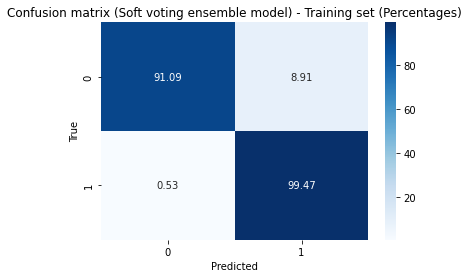

Test set:
F1 Score (Per Class): [0.84134367 0.65073948]
AUC Score: 0.7641992294991744


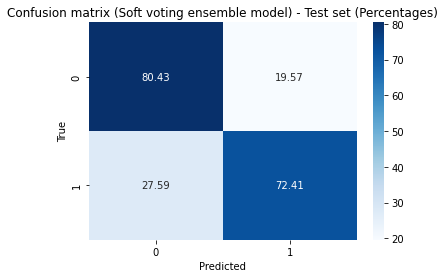

In [19]:
# Evaluate the updated soft voting ensemble
evaluate_model("Soft voting ensemble", soft_vote_train_preds, soft_vote_test_preds)

In [20]:
# Stacking ensemble
stacking = StackingClassifier(
    estimators=[('svm', best_svm_pipe), ('nb', nb), ('lgbm', best_mod), ('xgb', lf_xgb), ('catboost', catboost_model), ('ada_boost', ada_boost)],
    final_estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
    passthrough=True,
    cv=5
)
stacking.fit(X_train, y_train)
stacking_train_preds = stacking.predict(X_train)
stacking_test_preds = stacking.predict(X_test)

0:	learn: 0.6625448	total: 7.29ms	remaining: 7.29s
1:	learn: 0.6343008	total: 16.9ms	remaining: 8.45s
2:	learn: 0.6108811	total: 26.6ms	remaining: 8.82s
3:	learn: 0.5941157	total: 34.7ms	remaining: 8.65s
4:	learn: 0.5762510	total: 43.3ms	remaining: 8.62s
5:	learn: 0.5631695	total: 52.4ms	remaining: 8.68s
6:	learn: 0.5496028	total: 60.6ms	remaining: 8.59s
7:	learn: 0.5370159	total: 70ms	remaining: 8.68s
8:	learn: 0.5265762	total: 79.3ms	remaining: 8.73s
9:	learn: 0.5171500	total: 87.1ms	remaining: 8.62s
10:	learn: 0.5105821	total: 94.8ms	remaining: 8.52s
11:	learn: 0.5035293	total: 103ms	remaining: 8.45s
12:	learn: 0.4985763	total: 111ms	remaining: 8.46s
13:	learn: 0.4939736	total: 123ms	remaining: 8.69s
14:	learn: 0.4885869	total: 133ms	remaining: 8.74s
15:	learn: 0.4832205	total: 142ms	remaining: 8.74s
16:	learn: 0.4786047	total: 151ms	remaining: 8.71s
17:	learn: 0.4745975	total: 159ms	remaining: 8.67s
18:	learn: 0.4713608	total: 168ms	remaining: 8.67s
19:	learn: 0.4685509	total: 177m

181:	learn: 0.3494627	total: 1.75s	remaining: 7.87s
182:	learn: 0.3490072	total: 1.76s	remaining: 7.85s
183:	learn: 0.3485822	total: 1.77s	remaining: 7.83s
184:	learn: 0.3481334	total: 1.77s	remaining: 7.82s
185:	learn: 0.3478214	total: 1.78s	remaining: 7.81s
186:	learn: 0.3470727	total: 1.81s	remaining: 7.87s
187:	learn: 0.3466055	total: 1.82s	remaining: 7.85s
188:	learn: 0.3463417	total: 1.82s	remaining: 7.83s
189:	learn: 0.3460847	total: 1.83s	remaining: 7.82s
190:	learn: 0.3457630	total: 1.85s	remaining: 7.84s
191:	learn: 0.3454983	total: 1.86s	remaining: 7.82s
192:	learn: 0.3449992	total: 1.87s	remaining: 7.81s
193:	learn: 0.3444856	total: 1.88s	remaining: 7.81s
194:	learn: 0.3439075	total: 1.89s	remaining: 7.8s
195:	learn: 0.3435720	total: 1.9s	remaining: 7.79s
196:	learn: 0.3432587	total: 1.92s	remaining: 7.82s
197:	learn: 0.3428230	total: 1.93s	remaining: 7.81s
198:	learn: 0.3425491	total: 1.94s	remaining: 7.79s
199:	learn: 0.3422031	total: 1.95s	remaining: 7.8s
200:	learn: 0.3

354:	learn: 0.2887673	total: 3.44s	remaining: 6.25s
355:	learn: 0.2884866	total: 3.44s	remaining: 6.23s
356:	learn: 0.2883326	total: 3.46s	remaining: 6.22s
357:	learn: 0.2878868	total: 3.46s	remaining: 6.21s
358:	learn: 0.2876511	total: 3.47s	remaining: 6.2s
359:	learn: 0.2874677	total: 3.48s	remaining: 6.18s
360:	learn: 0.2872675	total: 3.5s	remaining: 6.19s
361:	learn: 0.2870973	total: 3.5s	remaining: 6.18s
362:	learn: 0.2868613	total: 3.52s	remaining: 6.17s
363:	learn: 0.2867359	total: 3.52s	remaining: 6.16s
364:	learn: 0.2865206	total: 3.53s	remaining: 6.15s
365:	learn: 0.2861470	total: 3.54s	remaining: 6.14s
366:	learn: 0.2857549	total: 3.55s	remaining: 6.13s
367:	learn: 0.2855310	total: 3.56s	remaining: 6.12s
368:	learn: 0.2852190	total: 3.57s	remaining: 6.11s
369:	learn: 0.2849516	total: 3.58s	remaining: 6.1s
370:	learn: 0.2846258	total: 3.59s	remaining: 6.09s
371:	learn: 0.2842492	total: 3.6s	remaining: 6.08s
372:	learn: 0.2840925	total: 3.61s	remaining: 6.07s
373:	learn: 0.283

529:	learn: 0.2454084	total: 5.12s	remaining: 4.54s
530:	learn: 0.2451745	total: 5.13s	remaining: 4.53s
531:	learn: 0.2450764	total: 5.14s	remaining: 4.52s
532:	learn: 0.2447967	total: 5.15s	remaining: 4.51s
533:	learn: 0.2445469	total: 5.16s	remaining: 4.5s
534:	learn: 0.2441779	total: 5.17s	remaining: 4.49s
535:	learn: 0.2440153	total: 5.18s	remaining: 4.48s
536:	learn: 0.2439119	total: 5.19s	remaining: 4.47s
537:	learn: 0.2437948	total: 5.2s	remaining: 4.46s
538:	learn: 0.2436671	total: 5.2s	remaining: 4.45s
539:	learn: 0.2434633	total: 5.21s	remaining: 4.44s
540:	learn: 0.2431437	total: 5.22s	remaining: 4.43s
541:	learn: 0.2429294	total: 5.23s	remaining: 4.42s
542:	learn: 0.2427548	total: 5.25s	remaining: 4.42s
543:	learn: 0.2425768	total: 5.26s	remaining: 4.41s
544:	learn: 0.2424000	total: 5.27s	remaining: 4.4s
545:	learn: 0.2420790	total: 5.28s	remaining: 4.39s
546:	learn: 0.2419602	total: 5.29s	remaining: 4.38s
547:	learn: 0.2417923	total: 5.3s	remaining: 4.37s
548:	learn: 0.241

696:	learn: 0.2126173	total: 6.84s	remaining: 2.97s
697:	learn: 0.2124553	total: 6.85s	remaining: 2.96s
698:	learn: 0.2123347	total: 6.86s	remaining: 2.95s
699:	learn: 0.2121892	total: 6.87s	remaining: 2.94s
700:	learn: 0.2121023	total: 6.88s	remaining: 2.93s
701:	learn: 0.2118043	total: 6.89s	remaining: 2.92s
702:	learn: 0.2115567	total: 6.91s	remaining: 2.92s
703:	learn: 0.2113212	total: 6.92s	remaining: 2.91s
704:	learn: 0.2111386	total: 6.93s	remaining: 2.9s
705:	learn: 0.2109307	total: 6.94s	remaining: 2.89s
706:	learn: 0.2107823	total: 6.95s	remaining: 2.88s
707:	learn: 0.2105424	total: 6.96s	remaining: 2.87s
708:	learn: 0.2103726	total: 6.96s	remaining: 2.86s
709:	learn: 0.2101366	total: 6.97s	remaining: 2.85s
710:	learn: 0.2099111	total: 6.98s	remaining: 2.84s
711:	learn: 0.2097100	total: 6.99s	remaining: 2.83s
712:	learn: 0.2095167	total: 7s	remaining: 2.82s
713:	learn: 0.2093818	total: 7.01s	remaining: 2.81s
714:	learn: 0.2091937	total: 7.02s	remaining: 2.8s
715:	learn: 0.208

867:	learn: 0.1855326	total: 8.55s	remaining: 1.3s
868:	learn: 0.1854343	total: 8.56s	remaining: 1.29s
869:	learn: 0.1853415	total: 8.57s	remaining: 1.28s
870:	learn: 0.1852699	total: 8.58s	remaining: 1.27s
871:	learn: 0.1850514	total: 8.59s	remaining: 1.26s
872:	learn: 0.1848883	total: 8.6s	remaining: 1.25s
873:	learn: 0.1846950	total: 8.61s	remaining: 1.24s
874:	learn: 0.1845479	total: 8.62s	remaining: 1.23s
875:	learn: 0.1843958	total: 8.62s	remaining: 1.22s
876:	learn: 0.1842443	total: 8.63s	remaining: 1.21s
877:	learn: 0.1841488	total: 8.64s	remaining: 1.2s
878:	learn: 0.1839720	total: 8.65s	remaining: 1.19s
879:	learn: 0.1838570	total: 8.66s	remaining: 1.18s
880:	learn: 0.1837536	total: 8.67s	remaining: 1.17s
881:	learn: 0.1835421	total: 8.68s	remaining: 1.16s
882:	learn: 0.1833972	total: 8.69s	remaining: 1.15s
883:	learn: 0.1831883	total: 8.7s	remaining: 1.14s
884:	learn: 0.1830917	total: 8.71s	remaining: 1.13s
885:	learn: 0.1829198	total: 8.72s	remaining: 1.12s
886:	learn: 0.18

42:	learn: 0.4252855	total: 385ms	remaining: 8.57s
43:	learn: 0.4236652	total: 391ms	remaining: 8.5s
44:	learn: 0.4223760	total: 398ms	remaining: 8.45s
45:	learn: 0.4212389	total: 403ms	remaining: 8.37s
46:	learn: 0.4202673	total: 409ms	remaining: 8.3s
47:	learn: 0.4192266	total: 420ms	remaining: 8.33s
48:	learn: 0.4180566	total: 426ms	remaining: 8.28s
49:	learn: 0.4168945	total: 432ms	remaining: 8.21s
50:	learn: 0.4155061	total: 438ms	remaining: 8.14s
51:	learn: 0.4146552	total: 444ms	remaining: 8.09s
52:	learn: 0.4139297	total: 450ms	remaining: 8.04s
53:	learn: 0.4129683	total: 455ms	remaining: 7.97s
54:	learn: 0.4124471	total: 461ms	remaining: 7.92s
55:	learn: 0.4116227	total: 465ms	remaining: 7.83s
56:	learn: 0.4110270	total: 471ms	remaining: 7.79s
57:	learn: 0.4102635	total: 476ms	remaining: 7.73s
58:	learn: 0.4094711	total: 483ms	remaining: 7.7s
59:	learn: 0.4082886	total: 489ms	remaining: 7.66s
60:	learn: 0.4075349	total: 494ms	remaining: 7.61s
61:	learn: 0.4066809	total: 511ms	

205:	learn: 0.3250455	total: 1.66s	remaining: 6.41s
206:	learn: 0.3246160	total: 1.69s	remaining: 6.48s
207:	learn: 0.3241374	total: 1.7s	remaining: 6.46s
208:	learn: 0.3236502	total: 1.71s	remaining: 6.48s
209:	learn: 0.3232408	total: 1.72s	remaining: 6.47s
210:	learn: 0.3227933	total: 1.73s	remaining: 6.46s
211:	learn: 0.3223568	total: 1.73s	remaining: 6.44s
212:	learn: 0.3219923	total: 1.76s	remaining: 6.5s
213:	learn: 0.3216667	total: 1.77s	remaining: 6.5s
214:	learn: 0.3212304	total: 1.79s	remaining: 6.53s
215:	learn: 0.3209640	total: 1.8s	remaining: 6.53s
216:	learn: 0.3205967	total: 1.81s	remaining: 6.53s
217:	learn: 0.3201542	total: 1.81s	remaining: 6.51s
218:	learn: 0.3198636	total: 1.82s	remaining: 6.5s
219:	learn: 0.3194295	total: 1.83s	remaining: 6.48s
220:	learn: 0.3190528	total: 1.86s	remaining: 6.55s
221:	learn: 0.3187502	total: 1.86s	remaining: 6.53s
222:	learn: 0.3183055	total: 1.87s	remaining: 6.52s
223:	learn: 0.3180668	total: 1.88s	remaining: 6.5s
224:	learn: 0.3173

364:	learn: 0.2688042	total: 2.97s	remaining: 5.17s
365:	learn: 0.2685016	total: 2.99s	remaining: 5.18s
366:	learn: 0.2682403	total: 3s	remaining: 5.18s
367:	learn: 0.2679780	total: 3.01s	remaining: 5.17s
368:	learn: 0.2676661	total: 3.01s	remaining: 5.15s
369:	learn: 0.2673595	total: 3.04s	remaining: 5.18s
370:	learn: 0.2671181	total: 3.05s	remaining: 5.17s
371:	learn: 0.2668426	total: 3.05s	remaining: 5.16s
372:	learn: 0.2664675	total: 3.06s	remaining: 5.14s
373:	learn: 0.2663420	total: 3.06s	remaining: 5.13s
374:	learn: 0.2659702	total: 3.07s	remaining: 5.12s
375:	learn: 0.2657332	total: 3.08s	remaining: 5.11s
376:	learn: 0.2655723	total: 3.08s	remaining: 5.1s
377:	learn: 0.2652941	total: 3.1s	remaining: 5.1s
378:	learn: 0.2649932	total: 3.11s	remaining: 5.09s
379:	learn: 0.2647514	total: 3.11s	remaining: 5.08s
380:	learn: 0.2644343	total: 3.12s	remaining: 5.07s
381:	learn: 0.2643114	total: 3.13s	remaining: 5.06s
382:	learn: 0.2639687	total: 3.13s	remaining: 5.04s
383:	learn: 0.2637

539:	learn: 0.2256450	total: 4.52s	remaining: 3.85s
540:	learn: 0.2255153	total: 4.53s	remaining: 3.85s
541:	learn: 0.2254198	total: 4.54s	remaining: 3.84s
542:	learn: 0.2252744	total: 4.56s	remaining: 3.84s
543:	learn: 0.2248877	total: 4.57s	remaining: 3.83s
544:	learn: 0.2245658	total: 4.57s	remaining: 3.82s
545:	learn: 0.2242716	total: 4.58s	remaining: 3.81s
546:	learn: 0.2241011	total: 4.59s	remaining: 3.8s
547:	learn: 0.2238761	total: 4.59s	remaining: 3.79s
548:	learn: 0.2235803	total: 4.6s	remaining: 3.78s
549:	learn: 0.2234223	total: 4.61s	remaining: 3.77s
550:	learn: 0.2232639	total: 4.61s	remaining: 3.76s
551:	learn: 0.2230848	total: 4.63s	remaining: 3.76s
552:	learn: 0.2228523	total: 4.65s	remaining: 3.76s
553:	learn: 0.2227277	total: 4.66s	remaining: 3.75s
554:	learn: 0.2225608	total: 4.66s	remaining: 3.74s
555:	learn: 0.2223144	total: 4.67s	remaining: 3.73s
556:	learn: 0.2221724	total: 4.69s	remaining: 3.73s
557:	learn: 0.2220266	total: 4.7s	remaining: 3.72s
558:	learn: 0.2

707:	learn: 0.1928392	total: 6.03s	remaining: 2.48s
708:	learn: 0.1926145	total: 6.03s	remaining: 2.48s
709:	learn: 0.1922179	total: 6.04s	remaining: 2.47s
710:	learn: 0.1919344	total: 6.05s	remaining: 2.46s
711:	learn: 0.1917526	total: 6.06s	remaining: 2.45s
712:	learn: 0.1915042	total: 6.06s	remaining: 2.44s
713:	learn: 0.1912794	total: 6.07s	remaining: 2.43s
714:	learn: 0.1911822	total: 6.08s	remaining: 2.42s
715:	learn: 0.1909838	total: 6.08s	remaining: 2.41s
716:	learn: 0.1907018	total: 6.09s	remaining: 2.4s
717:	learn: 0.1904371	total: 6.1s	remaining: 2.4s
718:	learn: 0.1902765	total: 6.11s	remaining: 2.39s
719:	learn: 0.1900936	total: 6.11s	remaining: 2.38s
720:	learn: 0.1899486	total: 6.13s	remaining: 2.37s
721:	learn: 0.1897620	total: 6.14s	remaining: 2.36s
722:	learn: 0.1896017	total: 6.14s	remaining: 2.35s
723:	learn: 0.1894713	total: 6.16s	remaining: 2.35s
724:	learn: 0.1892100	total: 6.17s	remaining: 2.34s
725:	learn: 0.1890237	total: 6.17s	remaining: 2.33s
726:	learn: 0.1

874:	learn: 0.1648541	total: 7.54s	remaining: 1.08s
875:	learn: 0.1646836	total: 7.54s	remaining: 1.07s
876:	learn: 0.1644813	total: 7.55s	remaining: 1.06s
877:	learn: 0.1643375	total: 7.57s	remaining: 1.05s
878:	learn: 0.1641416	total: 7.58s	remaining: 1.04s
879:	learn: 0.1639505	total: 7.58s	remaining: 1.03s
880:	learn: 0.1638784	total: 7.6s	remaining: 1.03s
881:	learn: 0.1636617	total: 7.61s	remaining: 1.02s
882:	learn: 0.1634915	total: 7.62s	remaining: 1.01s
883:	learn: 0.1633587	total: 7.63s	remaining: 1s
884:	learn: 0.1632794	total: 7.63s	remaining: 992ms
885:	learn: 0.1631746	total: 7.64s	remaining: 984ms
886:	learn: 0.1630497	total: 7.65s	remaining: 975ms
887:	learn: 0.1629468	total: 7.66s	remaining: 967ms
888:	learn: 0.1628073	total: 7.68s	remaining: 959ms
889:	learn: 0.1627561	total: 7.7s	remaining: 952ms
890:	learn: 0.1625720	total: 7.71s	remaining: 944ms
891:	learn: 0.1624458	total: 7.73s	remaining: 936ms
892:	learn: 0.1622766	total: 7.74s	remaining: 927ms
893:	learn: 0.162

38:	learn: 0.4258386	total: 368ms	remaining: 9.08s
39:	learn: 0.4245052	total: 391ms	remaining: 9.39s
40:	learn: 0.4233578	total: 397ms	remaining: 9.3s
41:	learn: 0.4221507	total: 421ms	remaining: 9.6s
42:	learn: 0.4207282	total: 428ms	remaining: 9.53s
43:	learn: 0.4196675	total: 436ms	remaining: 9.46s
44:	learn: 0.4183277	total: 442ms	remaining: 9.38s
45:	learn: 0.4168302	total: 457ms	remaining: 9.48s
46:	learn: 0.4159700	total: 464ms	remaining: 9.4s
47:	learn: 0.4145275	total: 469ms	remaining: 9.31s
48:	learn: 0.4135032	total: 476ms	remaining: 9.23s
49:	learn: 0.4121073	total: 509ms	remaining: 9.67s
50:	learn: 0.4112098	total: 516ms	remaining: 9.6s
51:	learn: 0.4098888	total: 523ms	remaining: 9.53s
52:	learn: 0.4093543	total: 529ms	remaining: 9.46s
53:	learn: 0.4083434	total: 539ms	remaining: 9.45s
54:	learn: 0.4075199	total: 559ms	remaining: 9.6s
55:	learn: 0.4067563	total: 566ms	remaining: 9.54s
56:	learn: 0.4062032	total: 588ms	remaining: 9.72s
57:	learn: 0.4052064	total: 594ms	re

216:	learn: 0.3221913	total: 2.06s	remaining: 7.42s
217:	learn: 0.3217866	total: 2.06s	remaining: 7.41s
218:	learn: 0.3211995	total: 2.07s	remaining: 7.39s
219:	learn: 0.3206080	total: 2.08s	remaining: 7.37s
220:	learn: 0.3202656	total: 2.09s	remaining: 7.36s
221:	learn: 0.3199023	total: 2.09s	remaining: 7.34s
222:	learn: 0.3194458	total: 2.1s	remaining: 7.32s
223:	learn: 0.3189235	total: 2.1s	remaining: 7.29s
224:	learn: 0.3186339	total: 2.11s	remaining: 7.27s
225:	learn: 0.3180498	total: 2.13s	remaining: 7.29s
226:	learn: 0.3176133	total: 2.13s	remaining: 7.27s
227:	learn: 0.3173903	total: 2.14s	remaining: 7.25s
228:	learn: 0.3169079	total: 2.15s	remaining: 7.23s
229:	learn: 0.3163854	total: 2.15s	remaining: 7.21s
230:	learn: 0.3161885	total: 2.17s	remaining: 7.21s
231:	learn: 0.3157908	total: 2.17s	remaining: 7.19s
232:	learn: 0.3155579	total: 2.19s	remaining: 7.19s
233:	learn: 0.3151128	total: 2.2s	remaining: 7.19s
234:	learn: 0.3143845	total: 2.2s	remaining: 7.17s
235:	learn: 0.31

384:	learn: 0.2643251	total: 3.58s	remaining: 5.71s
385:	learn: 0.2639329	total: 3.58s	remaining: 5.7s
386:	learn: 0.2636702	total: 3.59s	remaining: 5.69s
387:	learn: 0.2633619	total: 3.6s	remaining: 5.68s
388:	learn: 0.2631039	total: 3.61s	remaining: 5.67s
389:	learn: 0.2626320	total: 3.62s	remaining: 5.66s
390:	learn: 0.2624268	total: 3.63s	remaining: 5.65s
391:	learn: 0.2621262	total: 3.63s	remaining: 5.63s
392:	learn: 0.2618866	total: 3.64s	remaining: 5.62s
393:	learn: 0.2614926	total: 3.65s	remaining: 5.62s
394:	learn: 0.2613307	total: 3.66s	remaining: 5.61s
395:	learn: 0.2611651	total: 3.67s	remaining: 5.6s
396:	learn: 0.2609427	total: 3.67s	remaining: 5.58s
397:	learn: 0.2606710	total: 3.68s	remaining: 5.57s
398:	learn: 0.2605503	total: 3.69s	remaining: 5.55s
399:	learn: 0.2601808	total: 3.69s	remaining: 5.54s
400:	learn: 0.2598886	total: 3.7s	remaining: 5.53s
401:	learn: 0.2595735	total: 3.7s	remaining: 5.51s
402:	learn: 0.2594097	total: 3.72s	remaining: 5.51s
403:	learn: 0.259

563:	learn: 0.2195933	total: 5.27s	remaining: 4.07s
564:	learn: 0.2194730	total: 5.27s	remaining: 4.06s
565:	learn: 0.2192192	total: 5.28s	remaining: 4.05s
566:	learn: 0.2189679	total: 5.29s	remaining: 4.04s
567:	learn: 0.2188096	total: 5.29s	remaining: 4.02s
568:	learn: 0.2187176	total: 5.3s	remaining: 4.01s
569:	learn: 0.2184152	total: 5.31s	remaining: 4s
570:	learn: 0.2182898	total: 5.32s	remaining: 3.99s
571:	learn: 0.2180071	total: 5.33s	remaining: 3.99s
572:	learn: 0.2176223	total: 5.34s	remaining: 3.98s
573:	learn: 0.2173011	total: 5.34s	remaining: 3.96s
574:	learn: 0.2171530	total: 5.35s	remaining: 3.95s
575:	learn: 0.2168583	total: 5.36s	remaining: 3.94s
576:	learn: 0.2166369	total: 5.37s	remaining: 3.94s
577:	learn: 0.2165014	total: 5.38s	remaining: 3.93s
578:	learn: 0.2162203	total: 5.39s	remaining: 3.92s
579:	learn: 0.2160653	total: 5.4s	remaining: 3.91s
580:	learn: 0.2157391	total: 5.4s	remaining: 3.9s
581:	learn: 0.2155522	total: 5.43s	remaining: 3.9s
582:	learn: 0.215332

734:	learn: 0.1859237	total: 6.81s	remaining: 2.46s
735:	learn: 0.1858493	total: 6.82s	remaining: 2.45s
736:	learn: 0.1856936	total: 6.82s	remaining: 2.44s
737:	learn: 0.1855473	total: 6.83s	remaining: 2.42s
738:	learn: 0.1853112	total: 6.84s	remaining: 2.41s
739:	learn: 0.1851540	total: 6.84s	remaining: 2.4s
740:	learn: 0.1849827	total: 6.85s	remaining: 2.39s
741:	learn: 0.1849421	total: 6.85s	remaining: 2.38s
742:	learn: 0.1846907	total: 6.87s	remaining: 2.37s
743:	learn: 0.1844831	total: 6.87s	remaining: 2.36s
744:	learn: 0.1841884	total: 6.88s	remaining: 2.35s
745:	learn: 0.1841078	total: 6.91s	remaining: 2.35s
746:	learn: 0.1838500	total: 6.91s	remaining: 2.34s
747:	learn: 0.1836426	total: 6.92s	remaining: 2.33s
748:	learn: 0.1835707	total: 6.92s	remaining: 2.32s
749:	learn: 0.1834924	total: 6.93s	remaining: 2.31s
750:	learn: 0.1833724	total: 6.94s	remaining: 2.3s
751:	learn: 0.1832228	total: 6.94s	remaining: 2.29s
752:	learn: 0.1831186	total: 6.95s	remaining: 2.28s
753:	learn: 0.

911:	learn: 0.1592790	total: 8.09s	remaining: 780ms
912:	learn: 0.1591903	total: 8.09s	remaining: 771ms
913:	learn: 0.1590882	total: 8.1s	remaining: 762ms
914:	learn: 0.1589310	total: 8.12s	remaining: 754ms
915:	learn: 0.1588178	total: 8.13s	remaining: 745ms
916:	learn: 0.1587050	total: 8.13s	remaining: 736ms
917:	learn: 0.1586288	total: 8.14s	remaining: 727ms
918:	learn: 0.1585708	total: 8.15s	remaining: 718ms
919:	learn: 0.1583821	total: 8.16s	remaining: 709ms
920:	learn: 0.1582340	total: 8.16s	remaining: 700ms
921:	learn: 0.1581163	total: 8.17s	remaining: 691ms
922:	learn: 0.1579866	total: 8.19s	remaining: 683ms
923:	learn: 0.1578525	total: 8.2s	remaining: 674ms
924:	learn: 0.1577929	total: 8.2s	remaining: 665ms
925:	learn: 0.1576669	total: 8.22s	remaining: 657ms
926:	learn: 0.1575816	total: 8.22s	remaining: 648ms
927:	learn: 0.1574887	total: 8.23s	remaining: 639ms
928:	learn: 0.1573298	total: 8.24s	remaining: 630ms
929:	learn: 0.1572298	total: 8.24s	remaining: 621ms
930:	learn: 0.1

84:	learn: 0.3965308	total: 753ms	remaining: 8.1s
85:	learn: 0.3960077	total: 759ms	remaining: 8.07s
86:	learn: 0.3953378	total: 765ms	remaining: 8.03s
87:	learn: 0.3946096	total: 772ms	remaining: 8s
88:	learn: 0.3940728	total: 778ms	remaining: 7.96s
89:	learn: 0.3935312	total: 794ms	remaining: 8.03s
90:	learn: 0.3929747	total: 814ms	remaining: 8.13s
91:	learn: 0.3923565	total: 825ms	remaining: 8.14s
92:	learn: 0.3920435	total: 831ms	remaining: 8.1s
93:	learn: 0.3914688	total: 842ms	remaining: 8.12s
94:	learn: 0.3910295	total: 848ms	remaining: 8.08s
95:	learn: 0.3903653	total: 855ms	remaining: 8.05s
96:	learn: 0.3894092	total: 861ms	remaining: 8.01s
97:	learn: 0.3887493	total: 867ms	remaining: 7.98s
98:	learn: 0.3878193	total: 873ms	remaining: 7.95s
99:	learn: 0.3875535	total: 878ms	remaining: 7.9s
100:	learn: 0.3869666	total: 884ms	remaining: 7.86s
101:	learn: 0.3863978	total: 889ms	remaining: 7.83s
102:	learn: 0.3857693	total: 895ms	remaining: 7.79s
103:	learn: 0.3852752	total: 901ms

251:	learn: 0.3221254	total: 2.28s	remaining: 6.77s
252:	learn: 0.3216865	total: 2.29s	remaining: 6.75s
253:	learn: 0.3215247	total: 2.29s	remaining: 6.73s
254:	learn: 0.3213097	total: 2.3s	remaining: 6.71s
255:	learn: 0.3209016	total: 2.32s	remaining: 6.74s
256:	learn: 0.3204506	total: 2.33s	remaining: 6.72s
257:	learn: 0.3202992	total: 2.33s	remaining: 6.71s
258:	learn: 0.3199889	total: 2.35s	remaining: 6.71s
259:	learn: 0.3197755	total: 2.36s	remaining: 6.71s
260:	learn: 0.3194257	total: 2.38s	remaining: 6.73s
261:	learn: 0.3191867	total: 2.38s	remaining: 6.71s
262:	learn: 0.3189274	total: 2.39s	remaining: 6.7s
263:	learn: 0.3186546	total: 2.4s	remaining: 6.68s
264:	learn: 0.3184758	total: 2.4s	remaining: 6.66s
265:	learn: 0.3181068	total: 2.41s	remaining: 6.65s
266:	learn: 0.3177614	total: 2.41s	remaining: 6.63s
267:	learn: 0.3174674	total: 2.42s	remaining: 6.61s
268:	learn: 0.3172225	total: 2.43s	remaining: 6.59s
269:	learn: 0.3167938	total: 2.43s	remaining: 6.58s
270:	learn: 0.31

427:	learn: 0.2682268	total: 3.94s	remaining: 5.27s
428:	learn: 0.2680496	total: 3.95s	remaining: 5.25s
429:	learn: 0.2677716	total: 3.95s	remaining: 5.24s
430:	learn: 0.2676344	total: 3.97s	remaining: 5.24s
431:	learn: 0.2671633	total: 3.98s	remaining: 5.23s
432:	learn: 0.2669128	total: 3.98s	remaining: 5.22s
433:	learn: 0.2667035	total: 3.99s	remaining: 5.21s
434:	learn: 0.2664149	total: 4s	remaining: 5.19s
435:	learn: 0.2662042	total: 4s	remaining: 5.18s
436:	learn: 0.2658079	total: 4.02s	remaining: 5.18s
437:	learn: 0.2656294	total: 4.03s	remaining: 5.16s
438:	learn: 0.2653237	total: 4.03s	remaining: 5.15s
439:	learn: 0.2649504	total: 4.04s	remaining: 5.14s
440:	learn: 0.2647549	total: 4.05s	remaining: 5.13s
441:	learn: 0.2644933	total: 4.05s	remaining: 5.12s
442:	learn: 0.2643177	total: 4.06s	remaining: 5.11s
443:	learn: 0.2640857	total: 4.07s	remaining: 5.09s
444:	learn: 0.2637269	total: 4.07s	remaining: 5.08s
445:	learn: 0.2635064	total: 4.08s	remaining: 5.07s
446:	learn: 0.2631

597:	learn: 0.2271432	total: 5.47s	remaining: 3.68s
598:	learn: 0.2269351	total: 5.48s	remaining: 3.67s
599:	learn: 0.2267119	total: 5.48s	remaining: 3.66s
600:	learn: 0.2265358	total: 5.5s	remaining: 3.65s
601:	learn: 0.2263482	total: 5.51s	remaining: 3.64s
602:	learn: 0.2261894	total: 5.51s	remaining: 3.63s
603:	learn: 0.2259501	total: 5.52s	remaining: 3.62s
604:	learn: 0.2257607	total: 5.53s	remaining: 3.61s
605:	learn: 0.2254953	total: 5.53s	remaining: 3.6s
606:	learn: 0.2253220	total: 5.54s	remaining: 3.59s
607:	learn: 0.2250701	total: 5.57s	remaining: 3.59s
608:	learn: 0.2248526	total: 5.57s	remaining: 3.58s
609:	learn: 0.2245735	total: 5.58s	remaining: 3.57s
610:	learn: 0.2243192	total: 5.58s	remaining: 3.56s
611:	learn: 0.2241331	total: 5.59s	remaining: 3.54s
612:	learn: 0.2238802	total: 5.6s	remaining: 3.53s
613:	learn: 0.2234857	total: 5.6s	remaining: 3.52s
614:	learn: 0.2233069	total: 5.61s	remaining: 3.51s
615:	learn: 0.2231924	total: 5.62s	remaining: 3.5s
616:	learn: 0.223

766:	learn: 0.1946772	total: 7s	remaining: 2.13s
767:	learn: 0.1945431	total: 7.01s	remaining: 2.12s
768:	learn: 0.1943433	total: 7.01s	remaining: 2.11s
769:	learn: 0.1942596	total: 7.03s	remaining: 2.1s
770:	learn: 0.1940865	total: 7.03s	remaining: 2.09s
771:	learn: 0.1939616	total: 7.04s	remaining: 2.08s
772:	learn: 0.1938155	total: 7.05s	remaining: 2.07s
773:	learn: 0.1935915	total: 7.05s	remaining: 2.06s
774:	learn: 0.1932861	total: 7.06s	remaining: 2.05s
775:	learn: 0.1931352	total: 7.06s	remaining: 2.04s
776:	learn: 0.1929827	total: 7.08s	remaining: 2.03s
777:	learn: 0.1928908	total: 7.08s	remaining: 2.02s
778:	learn: 0.1927886	total: 7.1s	remaining: 2.02s
779:	learn: 0.1926625	total: 7.11s	remaining: 2s
780:	learn: 0.1925086	total: 7.12s	remaining: 2s
781:	learn: 0.1923849	total: 7.13s	remaining: 1.99s
782:	learn: 0.1923210	total: 7.13s	remaining: 1.98s
783:	learn: 0.1921035	total: 7.14s	remaining: 1.97s
784:	learn: 0.1919212	total: 7.15s	remaining: 1.96s
785:	learn: 0.1917947	t

925:	learn: 0.1701999	total: 8.5s	remaining: 680ms
926:	learn: 0.1699982	total: 8.51s	remaining: 670ms
927:	learn: 0.1698362	total: 8.52s	remaining: 661ms
928:	learn: 0.1696687	total: 8.52s	remaining: 651ms
929:	learn: 0.1695796	total: 8.53s	remaining: 642ms
930:	learn: 0.1694799	total: 8.54s	remaining: 633ms
931:	learn: 0.1693429	total: 8.54s	remaining: 623ms
932:	learn: 0.1691907	total: 8.55s	remaining: 614ms
933:	learn: 0.1689617	total: 8.56s	remaining: 605ms
934:	learn: 0.1688487	total: 8.56s	remaining: 595ms
935:	learn: 0.1687076	total: 8.57s	remaining: 586ms
936:	learn: 0.1685312	total: 8.58s	remaining: 577ms
937:	learn: 0.1683411	total: 8.58s	remaining: 567ms
938:	learn: 0.1682499	total: 8.59s	remaining: 558ms
939:	learn: 0.1681718	total: 8.6s	remaining: 549ms
940:	learn: 0.1680100	total: 8.6s	remaining: 539ms
941:	learn: 0.1678762	total: 8.62s	remaining: 531ms
942:	learn: 0.1677614	total: 8.63s	remaining: 522ms
943:	learn: 0.1676046	total: 8.64s	remaining: 513ms
944:	learn: 0.1

108:	learn: 0.3854742	total: 960ms	remaining: 7.85s
109:	learn: 0.3850944	total: 967ms	remaining: 7.82s
110:	learn: 0.3847000	total: 985ms	remaining: 7.89s
111:	learn: 0.3841385	total: 992ms	remaining: 7.86s
112:	learn: 0.3835480	total: 998ms	remaining: 7.83s
113:	learn: 0.3828681	total: 1.02s	remaining: 7.97s
114:	learn: 0.3823257	total: 1.03s	remaining: 7.94s
115:	learn: 0.3812976	total: 1.04s	remaining: 7.96s
116:	learn: 0.3808535	total: 1.05s	remaining: 7.93s
117:	learn: 0.3803525	total: 1.06s	remaining: 7.94s
118:	learn: 0.3796785	total: 1.07s	remaining: 7.91s
119:	learn: 0.3787732	total: 1.08s	remaining: 7.95s
120:	learn: 0.3783806	total: 1.09s	remaining: 7.92s
121:	learn: 0.3780455	total: 1.1s	remaining: 7.91s
122:	learn: 0.3776336	total: 1.1s	remaining: 7.88s
123:	learn: 0.3771341	total: 1.11s	remaining: 7.86s
124:	learn: 0.3766576	total: 1.12s	remaining: 7.83s
125:	learn: 0.3761775	total: 1.12s	remaining: 7.8s
126:	learn: 0.3758488	total: 1.13s	remaining: 7.78s
127:	learn: 0.3

271:	learn: 0.3134014	total: 2.46s	remaining: 6.59s
272:	learn: 0.3129574	total: 2.48s	remaining: 6.6s
273:	learn: 0.3125434	total: 2.48s	remaining: 6.58s
274:	learn: 0.3120823	total: 2.49s	remaining: 6.57s
275:	learn: 0.3117407	total: 2.5s	remaining: 6.56s
276:	learn: 0.3114641	total: 2.51s	remaining: 6.54s
277:	learn: 0.3110970	total: 2.51s	remaining: 6.53s
278:	learn: 0.3107038	total: 2.52s	remaining: 6.51s
279:	learn: 0.3103656	total: 2.53s	remaining: 6.52s
280:	learn: 0.3100143	total: 2.54s	remaining: 6.5s
281:	learn: 0.3098196	total: 2.55s	remaining: 6.49s
282:	learn: 0.3096403	total: 2.56s	remaining: 6.48s
283:	learn: 0.3093326	total: 2.57s	remaining: 6.47s
284:	learn: 0.3089569	total: 2.57s	remaining: 6.45s
285:	learn: 0.3085119	total: 2.58s	remaining: 6.43s
286:	learn: 0.3081918	total: 2.58s	remaining: 6.42s
287:	learn: 0.3076808	total: 2.59s	remaining: 6.4s
288:	learn: 0.3074392	total: 2.6s	remaining: 6.39s
289:	learn: 0.3071414	total: 2.6s	remaining: 6.38s
290:	learn: 0.3066

445:	learn: 0.2589195	total: 3.94s	remaining: 4.9s
446:	learn: 0.2585818	total: 3.95s	remaining: 4.89s
447:	learn: 0.2582515	total: 3.96s	remaining: 4.88s
448:	learn: 0.2578826	total: 3.96s	remaining: 4.86s
449:	learn: 0.2575882	total: 3.97s	remaining: 4.85s
450:	learn: 0.2571870	total: 3.98s	remaining: 4.84s
451:	learn: 0.2569980	total: 3.98s	remaining: 4.83s
452:	learn: 0.2567764	total: 3.99s	remaining: 4.82s
453:	learn: 0.2565934	total: 4s	remaining: 4.8s
454:	learn: 0.2563887	total: 4s	remaining: 4.79s
455:	learn: 0.2562174	total: 4.01s	remaining: 4.78s
456:	learn: 0.2559170	total: 4.01s	remaining: 4.77s
457:	learn: 0.2557395	total: 4.02s	remaining: 4.76s
458:	learn: 0.2553252	total: 4.03s	remaining: 4.75s
459:	learn: 0.2551249	total: 4.03s	remaining: 4.73s
460:	learn: 0.2547111	total: 4.04s	remaining: 4.72s
461:	learn: 0.2543597	total: 4.04s	remaining: 4.71s
462:	learn: 0.2541527	total: 4.05s	remaining: 4.7s
463:	learn: 0.2539366	total: 4.06s	remaining: 4.69s
464:	learn: 0.2537337

604:	learn: 0.2216655	total: 5.07s	remaining: 3.31s
605:	learn: 0.2213909	total: 5.07s	remaining: 3.3s
606:	learn: 0.2211405	total: 5.08s	remaining: 3.29s
607:	learn: 0.2210219	total: 5.08s	remaining: 3.28s
608:	learn: 0.2208818	total: 5.1s	remaining: 3.28s
609:	learn: 0.2207078	total: 5.11s	remaining: 3.27s
610:	learn: 0.2205108	total: 5.11s	remaining: 3.25s
611:	learn: 0.2202603	total: 5.12s	remaining: 3.25s
612:	learn: 0.2199934	total: 5.12s	remaining: 3.23s
613:	learn: 0.2198447	total: 5.13s	remaining: 3.22s
614:	learn: 0.2196843	total: 5.13s	remaining: 3.21s
615:	learn: 0.2195280	total: 5.14s	remaining: 3.2s
616:	learn: 0.2192803	total: 5.14s	remaining: 3.19s
617:	learn: 0.2191421	total: 5.15s	remaining: 3.18s
618:	learn: 0.2189227	total: 5.15s	remaining: 3.17s
619:	learn: 0.2186977	total: 5.15s	remaining: 3.16s
620:	learn: 0.2185198	total: 5.16s	remaining: 3.15s
621:	learn: 0.2183190	total: 5.16s	remaining: 3.14s
622:	learn: 0.2180269	total: 5.17s	remaining: 3.13s
623:	learn: 0.2

774:	learn: 0.1908498	total: 6.39s	remaining: 1.85s
775:	learn: 0.1907864	total: 6.39s	remaining: 1.84s
776:	learn: 0.1906378	total: 6.4s	remaining: 1.84s
777:	learn: 0.1905344	total: 6.41s	remaining: 1.83s
778:	learn: 0.1904104	total: 6.42s	remaining: 1.82s
779:	learn: 0.1902335	total: 6.42s	remaining: 1.81s
780:	learn: 0.1899939	total: 6.43s	remaining: 1.8s
781:	learn: 0.1898860	total: 6.44s	remaining: 1.79s
782:	learn: 0.1897175	total: 6.46s	remaining: 1.79s
783:	learn: 0.1895881	total: 6.46s	remaining: 1.78s
784:	learn: 0.1894803	total: 6.48s	remaining: 1.77s
785:	learn: 0.1893448	total: 6.49s	remaining: 1.77s
786:	learn: 0.1891310	total: 6.5s	remaining: 1.76s
787:	learn: 0.1889675	total: 6.5s	remaining: 1.75s
788:	learn: 0.1887670	total: 6.52s	remaining: 1.74s
789:	learn: 0.1885861	total: 6.53s	remaining: 1.74s
790:	learn: 0.1883972	total: 6.54s	remaining: 1.73s
791:	learn: 0.1881287	total: 6.54s	remaining: 1.72s
792:	learn: 0.1879332	total: 6.55s	remaining: 1.71s
793:	learn: 0.18

947:	learn: 0.1647335	total: 7.89s	remaining: 433ms
948:	learn: 0.1645059	total: 7.9s	remaining: 425ms
949:	learn: 0.1644309	total: 7.92s	remaining: 417ms
950:	learn: 0.1643406	total: 7.92s	remaining: 408ms
951:	learn: 0.1641978	total: 7.93s	remaining: 400ms
952:	learn: 0.1639963	total: 7.95s	remaining: 392ms
953:	learn: 0.1638814	total: 7.96s	remaining: 384ms
954:	learn: 0.1637278	total: 7.96s	remaining: 375ms
955:	learn: 0.1636209	total: 7.97s	remaining: 367ms
956:	learn: 0.1635126	total: 7.98s	remaining: 359ms
957:	learn: 0.1633219	total: 7.99s	remaining: 350ms
958:	learn: 0.1632465	total: 8s	remaining: 342ms
959:	learn: 0.1631187	total: 8.01s	remaining: 334ms
960:	learn: 0.1629633	total: 8.01s	remaining: 325ms
961:	learn: 0.1628676	total: 8.03s	remaining: 317ms
962:	learn: 0.1628034	total: 8.04s	remaining: 309ms
963:	learn: 0.1626088	total: 8.05s	remaining: 301ms
964:	learn: 0.1625050	total: 8.06s	remaining: 292ms
965:	learn: 0.1624257	total: 8.07s	remaining: 284ms
966:	learn: 0.16

121:	learn: 0.3763955	total: 1.16s	remaining: 8.32s
122:	learn: 0.3757380	total: 1.17s	remaining: 8.31s
123:	learn: 0.3750069	total: 1.17s	remaining: 8.3s
124:	learn: 0.3746578	total: 1.18s	remaining: 8.28s
125:	learn: 0.3741288	total: 1.19s	remaining: 8.26s
126:	learn: 0.3734669	total: 1.21s	remaining: 8.3s
127:	learn: 0.3731279	total: 1.22s	remaining: 8.28s
128:	learn: 0.3728188	total: 1.22s	remaining: 8.26s
129:	learn: 0.3721934	total: 1.23s	remaining: 8.24s
130:	learn: 0.3716901	total: 1.24s	remaining: 8.22s
131:	learn: 0.3710545	total: 1.25s	remaining: 8.19s
132:	learn: 0.3706300	total: 1.25s	remaining: 8.18s
133:	learn: 0.3701435	total: 1.26s	remaining: 8.16s
134:	learn: 0.3699074	total: 1.27s	remaining: 8.14s
135:	learn: 0.3695684	total: 1.28s	remaining: 8.12s
136:	learn: 0.3691450	total: 1.29s	remaining: 8.1s
137:	learn: 0.3683129	total: 1.3s	remaining: 8.15s
138:	learn: 0.3680015	total: 1.31s	remaining: 8.13s
139:	learn: 0.3674255	total: 1.32s	remaining: 8.11s
140:	learn: 0.36

293:	learn: 0.3048002	total: 2.85s	remaining: 6.84s
294:	learn: 0.3045879	total: 2.85s	remaining: 6.82s
295:	learn: 0.3043414	total: 2.87s	remaining: 6.82s
296:	learn: 0.3040059	total: 2.88s	remaining: 6.81s
297:	learn: 0.3038607	total: 2.88s	remaining: 6.79s
298:	learn: 0.3035482	total: 2.89s	remaining: 6.78s
299:	learn: 0.3031857	total: 2.9s	remaining: 6.76s
300:	learn: 0.3029922	total: 2.9s	remaining: 6.74s
301:	learn: 0.3026977	total: 2.91s	remaining: 6.73s
302:	learn: 0.3024213	total: 2.93s	remaining: 6.75s
303:	learn: 0.3020752	total: 2.96s	remaining: 6.77s
304:	learn: 0.3018196	total: 2.96s	remaining: 6.75s
305:	learn: 0.3015907	total: 2.97s	remaining: 6.74s
306:	learn: 0.3012602	total: 2.98s	remaining: 6.73s
307:	learn: 0.3009347	total: 2.99s	remaining: 6.71s
308:	learn: 0.3006663	total: 3s	remaining: 6.7s
309:	learn: 0.3003438	total: 3s	remaining: 6.69s
310:	learn: 0.2999882	total: 3.01s	remaining: 6.67s
311:	learn: 0.2996294	total: 3.02s	remaining: 6.66s
312:	learn: 0.2993523

466:	learn: 0.2572481	total: 4.5s	remaining: 5.14s
467:	learn: 0.2568703	total: 4.51s	remaining: 5.13s
468:	learn: 0.2566680	total: 4.54s	remaining: 5.14s
469:	learn: 0.2564575	total: 4.54s	remaining: 5.13s
470:	learn: 0.2562805	total: 4.55s	remaining: 5.12s
471:	learn: 0.2560706	total: 4.56s	remaining: 5.1s
472:	learn: 0.2558115	total: 4.57s	remaining: 5.09s
473:	learn: 0.2555042	total: 4.58s	remaining: 5.08s
474:	learn: 0.2551821	total: 4.58s	remaining: 5.07s
475:	learn: 0.2548870	total: 4.6s	remaining: 5.07s
476:	learn: 0.2547161	total: 4.62s	remaining: 5.07s
477:	learn: 0.2545107	total: 4.64s	remaining: 5.07s
478:	learn: 0.2542733	total: 4.65s	remaining: 5.06s
479:	learn: 0.2540935	total: 4.66s	remaining: 5.04s
480:	learn: 0.2537871	total: 4.67s	remaining: 5.03s
481:	learn: 0.2536699	total: 4.67s	remaining: 5.02s
482:	learn: 0.2533635	total: 4.68s	remaining: 5.01s
483:	learn: 0.2530897	total: 4.69s	remaining: 5s
484:	learn: 0.2527552	total: 4.7s	remaining: 4.99s
485:	learn: 0.25261

628:	learn: 0.2204176	total: 5.99s	remaining: 3.53s
629:	learn: 0.2203315	total: 6s	remaining: 3.52s
630:	learn: 0.2200733	total: 6.01s	remaining: 3.51s
631:	learn: 0.2199084	total: 6.04s	remaining: 3.52s
632:	learn: 0.2196045	total: 6.05s	remaining: 3.51s
633:	learn: 0.2192837	total: 6.06s	remaining: 3.5s
634:	learn: 0.2190227	total: 6.07s	remaining: 3.49s
635:	learn: 0.2188796	total: 6.07s	remaining: 3.48s
636:	learn: 0.2187308	total: 6.08s	remaining: 3.47s
637:	learn: 0.2184556	total: 6.09s	remaining: 3.46s
638:	learn: 0.2181904	total: 6.1s	remaining: 3.44s
639:	learn: 0.2179388	total: 6.1s	remaining: 3.43s
640:	learn: 0.2177946	total: 6.11s	remaining: 3.42s
641:	learn: 0.2175440	total: 6.12s	remaining: 3.41s
642:	learn: 0.2173722	total: 6.13s	remaining: 3.4s
643:	learn: 0.2171603	total: 6.14s	remaining: 3.39s
644:	learn: 0.2169131	total: 6.14s	remaining: 3.38s
645:	learn: 0.2166987	total: 6.15s	remaining: 3.37s
646:	learn: 0.2165202	total: 6.16s	remaining: 3.36s
647:	learn: 0.21630

799:	learn: 0.1888568	total: 7.51s	remaining: 1.88s
800:	learn: 0.1886335	total: 7.51s	remaining: 1.87s
801:	learn: 0.1885054	total: 7.52s	remaining: 1.86s
802:	learn: 0.1883515	total: 7.53s	remaining: 1.85s
803:	learn: 0.1882093	total: 7.54s	remaining: 1.84s
804:	learn: 0.1880772	total: 7.54s	remaining: 1.83s
805:	learn: 0.1879714	total: 7.55s	remaining: 1.82s
806:	learn: 0.1878120	total: 7.56s	remaining: 1.81s
807:	learn: 0.1876869	total: 7.57s	remaining: 1.8s
808:	learn: 0.1875971	total: 7.58s	remaining: 1.79s
809:	learn: 0.1874656	total: 7.58s	remaining: 1.78s
810:	learn: 0.1873568	total: 7.59s	remaining: 1.77s
811:	learn: 0.1872330	total: 7.6s	remaining: 1.76s
812:	learn: 0.1870350	total: 7.61s	remaining: 1.75s
813:	learn: 0.1869263	total: 7.62s	remaining: 1.74s
814:	learn: 0.1867220	total: 7.65s	remaining: 1.74s
815:	learn: 0.1865665	total: 7.66s	remaining: 1.73s
816:	learn: 0.1864527	total: 7.67s	remaining: 1.72s
817:	learn: 0.1863499	total: 7.67s	remaining: 1.71s
818:	learn: 0.

961:	learn: 0.1656981	total: 9.02s	remaining: 356ms
962:	learn: 0.1656077	total: 9.02s	remaining: 347ms
963:	learn: 0.1654625	total: 9.03s	remaining: 337ms
964:	learn: 0.1653290	total: 9.04s	remaining: 328ms
965:	learn: 0.1652323	total: 9.05s	remaining: 318ms
966:	learn: 0.1650778	total: 9.06s	remaining: 309ms
967:	learn: 0.1648846	total: 9.06s	remaining: 300ms
968:	learn: 0.1647827	total: 9.07s	remaining: 290ms
969:	learn: 0.1646655	total: 9.08s	remaining: 281ms
970:	learn: 0.1646037	total: 9.09s	remaining: 271ms
971:	learn: 0.1645300	total: 9.1s	remaining: 262ms
972:	learn: 0.1644709	total: 9.1s	remaining: 253ms
973:	learn: 0.1642731	total: 9.11s	remaining: 243ms
974:	learn: 0.1641623	total: 9.12s	remaining: 234ms
975:	learn: 0.1640659	total: 9.13s	remaining: 224ms
976:	learn: 0.1638855	total: 9.13s	remaining: 215ms
977:	learn: 0.1637499	total: 9.14s	remaining: 206ms
978:	learn: 0.1636068	total: 9.15s	remaining: 196ms
979:	learn: 0.1633672	total: 9.16s	remaining: 187ms
980:	learn: 0.

Evaluation of Stacking ensemble model:
Training set:
F1 Score (Per Class): [0.9867246  0.98677567]
AUC Score: 0.9867501806793544


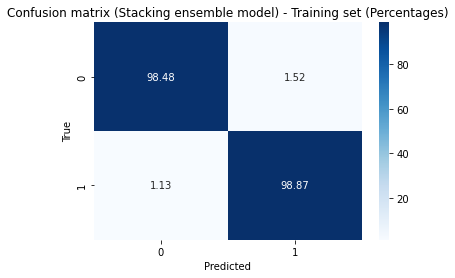

Test set:
F1 Score (Per Class): [0.8656015  0.58309038]
AUC Score: 0.7082040826537248


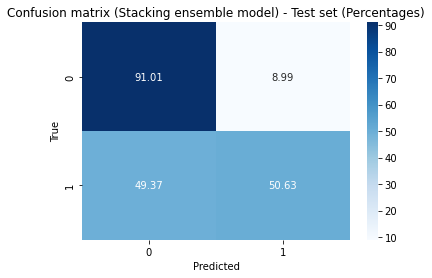

In [21]:
# Evaluate stacking ensemble
evaluate_model("Stacking ensemble", stacking_train_preds, stacking_test_preds)

In [22]:
# Soft voting ensemble without weights
soft_vote = VotingClassifier(
    estimators=[
        ('svm', best_svm_pipe), ('nb', nb), ('lgbm', best_mod),
        ('xgb', lf_xgb), ('ada_boost', ada_boost), ('rfc', rfc), ('catboost', catboost_model)
    ],
    voting='soft',
)
soft_vote.fit(X_train, y_train)
soft_vote_train_preds = soft_vote.predict(X_train)
soft_vote_test_preds = soft_vote.predict(X_test)[

0:	learn: 0.6625448	total: 13.1ms	remaining: 13.1s
1:	learn: 0.6343008	total: 34ms	remaining: 17s
2:	learn: 0.6108811	total: 41.1ms	remaining: 13.7s
3:	learn: 0.5941157	total: 48.6ms	remaining: 12.1s
4:	learn: 0.5762510	total: 56ms	remaining: 11.1s
5:	learn: 0.5631695	total: 63.9ms	remaining: 10.6s
6:	learn: 0.5496028	total: 70.6ms	remaining: 10s
7:	learn: 0.5370159	total: 95.1ms	remaining: 11.8s
8:	learn: 0.5265762	total: 103ms	remaining: 11.3s
9:	learn: 0.5171500	total: 111ms	remaining: 11s
10:	learn: 0.5105821	total: 118ms	remaining: 10.6s
11:	learn: 0.5035293	total: 124ms	remaining: 10.2s
12:	learn: 0.4985763	total: 132ms	remaining: 9.99s
13:	learn: 0.4939736	total: 139ms	remaining: 9.81s
14:	learn: 0.4885869	total: 146ms	remaining: 9.59s
15:	learn: 0.4832205	total: 153ms	remaining: 9.42s
16:	learn: 0.4786047	total: 160ms	remaining: 9.27s
17:	learn: 0.4745975	total: 168ms	remaining: 9.15s
18:	learn: 0.4713608	total: 189ms	remaining: 9.77s
19:	learn: 0.4685509	total: 204ms	remaining

166:	learn: 0.3558588	total: 1.75s	remaining: 8.71s
167:	learn: 0.3553172	total: 1.75s	remaining: 8.68s
168:	learn: 0.3549834	total: 1.76s	remaining: 8.65s
169:	learn: 0.3546857	total: 1.77s	remaining: 8.62s
170:	learn: 0.3542513	total: 1.77s	remaining: 8.6s
171:	learn: 0.3539598	total: 1.78s	remaining: 8.57s
172:	learn: 0.3534738	total: 1.79s	remaining: 8.55s
173:	learn: 0.3530583	total: 1.79s	remaining: 8.52s
174:	learn: 0.3526209	total: 1.8s	remaining: 8.5s
175:	learn: 0.3522228	total: 1.81s	remaining: 8.48s
176:	learn: 0.3518942	total: 1.82s	remaining: 8.46s
177:	learn: 0.3514961	total: 1.83s	remaining: 8.44s
178:	learn: 0.3507961	total: 1.84s	remaining: 8.46s
179:	learn: 0.3504633	total: 1.86s	remaining: 8.47s
180:	learn: 0.3500361	total: 1.87s	remaining: 8.44s
181:	learn: 0.3494627	total: 1.87s	remaining: 8.42s
182:	learn: 0.3490072	total: 1.88s	remaining: 8.4s
183:	learn: 0.3485822	total: 1.89s	remaining: 8.38s
184:	learn: 0.3481334	total: 1.9s	remaining: 8.35s
185:	learn: 0.347

343:	learn: 0.2913896	total: 3.26s	remaining: 6.21s
344:	learn: 0.2911617	total: 3.27s	remaining: 6.2s
345:	learn: 0.2908906	total: 3.27s	remaining: 6.19s
346:	learn: 0.2906260	total: 3.3s	remaining: 6.21s
347:	learn: 0.2904305	total: 3.3s	remaining: 6.19s
348:	learn: 0.2899246	total: 3.31s	remaining: 6.17s
349:	learn: 0.2897125	total: 3.32s	remaining: 6.16s
350:	learn: 0.2895008	total: 3.33s	remaining: 6.15s
351:	learn: 0.2893563	total: 3.35s	remaining: 6.16s
352:	learn: 0.2891730	total: 3.35s	remaining: 6.15s
353:	learn: 0.2889856	total: 3.36s	remaining: 6.14s
354:	learn: 0.2887673	total: 3.37s	remaining: 6.12s
355:	learn: 0.2884866	total: 3.38s	remaining: 6.11s
356:	learn: 0.2883326	total: 3.38s	remaining: 6.1s
357:	learn: 0.2878868	total: 3.39s	remaining: 6.09s
358:	learn: 0.2876511	total: 3.4s	remaining: 6.07s
359:	learn: 0.2874677	total: 3.41s	remaining: 6.06s
360:	learn: 0.2872675	total: 3.42s	remaining: 6.05s
361:	learn: 0.2870973	total: 3.42s	remaining: 6.03s
362:	learn: 0.286

512:	learn: 0.2492624	total: 4.74s	remaining: 4.5s
513:	learn: 0.2489963	total: 4.76s	remaining: 4.5s
514:	learn: 0.2488114	total: 4.77s	remaining: 4.49s
515:	learn: 0.2485418	total: 4.78s	remaining: 4.48s
516:	learn: 0.2484193	total: 4.79s	remaining: 4.47s
517:	learn: 0.2482796	total: 4.79s	remaining: 4.46s
518:	learn: 0.2481695	total: 4.8s	remaining: 4.45s
519:	learn: 0.2479997	total: 4.81s	remaining: 4.44s
520:	learn: 0.2477740	total: 4.81s	remaining: 4.42s
521:	learn: 0.2474487	total: 4.82s	remaining: 4.41s
522:	learn: 0.2471235	total: 4.83s	remaining: 4.4s
523:	learn: 0.2468132	total: 4.83s	remaining: 4.39s
524:	learn: 0.2465560	total: 4.85s	remaining: 4.39s
525:	learn: 0.2463205	total: 4.86s	remaining: 4.38s
526:	learn: 0.2460571	total: 4.87s	remaining: 4.37s
527:	learn: 0.2459249	total: 4.88s	remaining: 4.37s
528:	learn: 0.2455556	total: 4.89s	remaining: 4.36s
529:	learn: 0.2454084	total: 4.9s	remaining: 4.34s
530:	learn: 0.2451745	total: 4.92s	remaining: 4.34s
531:	learn: 0.245

675:	learn: 0.2166649	total: 6.25s	remaining: 3s
676:	learn: 0.2164525	total: 6.26s	remaining: 2.98s
677:	learn: 0.2162339	total: 6.26s	remaining: 2.98s
678:	learn: 0.2160602	total: 6.27s	remaining: 2.96s
679:	learn: 0.2159530	total: 6.28s	remaining: 2.96s
680:	learn: 0.2156937	total: 6.31s	remaining: 2.96s
681:	learn: 0.2154514	total: 6.33s	remaining: 2.95s
682:	learn: 0.2150915	total: 6.34s	remaining: 2.94s
683:	learn: 0.2149157	total: 6.35s	remaining: 2.93s
684:	learn: 0.2147429	total: 6.36s	remaining: 2.92s
685:	learn: 0.2146241	total: 6.36s	remaining: 2.91s
686:	learn: 0.2144501	total: 6.37s	remaining: 2.9s
687:	learn: 0.2142724	total: 6.38s	remaining: 2.89s
688:	learn: 0.2140719	total: 6.4s	remaining: 2.89s
689:	learn: 0.2138770	total: 6.41s	remaining: 2.88s
690:	learn: 0.2137351	total: 6.42s	remaining: 2.87s
691:	learn: 0.2134581	total: 6.43s	remaining: 2.86s
692:	learn: 0.2133299	total: 6.43s	remaining: 2.85s
693:	learn: 0.2131694	total: 6.44s	remaining: 2.84s
694:	learn: 0.212

855:	learn: 0.1872346	total: 7.76s	remaining: 1.3s
856:	learn: 0.1870967	total: 7.76s	remaining: 1.29s
857:	learn: 0.1870045	total: 7.77s	remaining: 1.29s
858:	learn: 0.1868247	total: 7.78s	remaining: 1.28s
859:	learn: 0.1867602	total: 7.79s	remaining: 1.27s
860:	learn: 0.1865434	total: 7.79s	remaining: 1.26s
861:	learn: 0.1863616	total: 7.8s	remaining: 1.25s
862:	learn: 0.1862868	total: 7.81s	remaining: 1.24s
863:	learn: 0.1861334	total: 7.82s	remaining: 1.23s
864:	learn: 0.1859613	total: 7.82s	remaining: 1.22s
865:	learn: 0.1858460	total: 7.83s	remaining: 1.21s
866:	learn: 0.1856828	total: 7.84s	remaining: 1.2s
867:	learn: 0.1855326	total: 7.84s	remaining: 1.19s
868:	learn: 0.1854343	total: 7.85s	remaining: 1.18s
869:	learn: 0.1853415	total: 7.86s	remaining: 1.17s
870:	learn: 0.1852699	total: 7.87s	remaining: 1.17s
871:	learn: 0.1850514	total: 7.88s	remaining: 1.16s
872:	learn: 0.1848883	total: 7.89s	remaining: 1.15s
873:	learn: 0.1846950	total: 7.89s	remaining: 1.14s
874:	learn: 0.1

Evaluation of Soft voting (no manual weights) ensemble model:
Training set:
F1 Score (Per Class): [0.90688466 0.91692308]
AUC Score: 0.9121898337749941


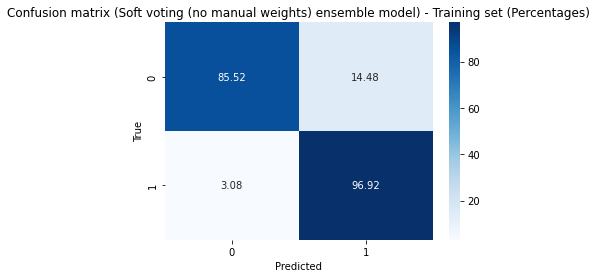

Test set:
F1 Score (Per Class): [0.83578947 0.65864333]
AUC Score: 0.7733051483464253


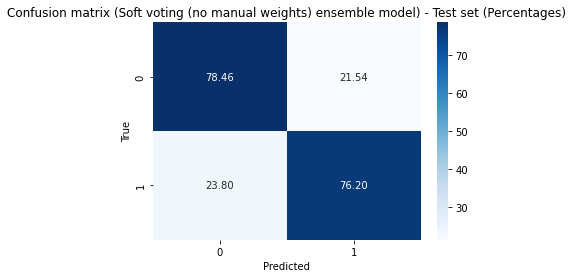

In [23]:
# Evaluate soft voting ensemble
evaluate_model("Soft voting (no manual weights) ensemble", soft_vote_train_preds, soft_vote_test_preds)